## Explore the co-author graph.
This notebook describes how to load the co-author graph.  

It also steps through the construction of a better property imbedding for each node based on the text key words using Gensim Doc2Vec.   

In [1]:
# Import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os
os.environ['DGLBACKEND'] = 'pytorch'  # tell DGL what to backend to use
import dgl
from dgl import DGLGraph
from dgl.data import Coauthor

import time
import numpy as np
import networkx as nx
#from res.plot_lib import set_default
import matplotlib.pyplot as plt
%matplotlib inline

Using backend: pytorch


In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [3]:
from dgl.data import Coauthor
x = Coauthor('cs')
coau = x[0]
coau

DGLGraph(num_nodes=18333, num_edges=327576,
         ndata_schemes={'feat': Scheme(shape=(6805,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={})

In [4]:
np.load = np_load_old

coau is a graph of 18333 authors.   edges represent paper coauthorship.  label is the classification topic interest of author.  
and feat is the vector consisting of the features of the author's papers from a vocabulary of length 6805

In [5]:
print(coau.ndata['label'])

tensor([13,  2, 13,  ...,  0,  8,  5])


In [6]:
coau.number_of_nodes()

18333

In [7]:
e = coau.edges()
print(e)
for i in range(10):
    print((e[0][i], e[1][i]))

(tensor([    0,     0,     0,  ..., 14816, 17748,  2582]), tensor([ 5111, 12716, 12963,  ..., 18331, 18331, 18332]))
(tensor(0), tensor(5111))
(tensor(0), tensor(12716))
(tensor(0), tensor(12963))
(tensor(0), tensor(13709))
(tensor(0), tensor(15763))
(tensor(1), tensor(1658))
(tensor(1), tensor(13273))
(tensor(1), tensor(14992))
(tensor(1), tensor(16269))
(tensor(2), tensor(2550))


In [19]:
coau.ndata

{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([13,  2, 13,  ...,  0,  8,  5])}

the following should be "https://github.com/shchur/gnn-benchmark/raw/master/data/npz/ms_academic_cs.npz"

In [18]:
cofull = np.load('C:/Users/ganno/.dgl/gnn_benckmark/ms_academic_cs.npz', allow_pickle=True)

In [20]:
cofull.

In [10]:
print(len(cofull['node_names']))
cofull['node_names']

18333


array(['0006BF12', '0007426B', '0009F1CA', ..., '863EDE12', '863EF8B5',
       '863F050A'], dtype='<U8')

In [11]:
cofull.files

['adj_data',
 'adj_indices',
 'adj_indptr',
 'adj_shape',
 'attr_data',
 'attr_indices',
 'attr_indptr',
 'attr_shape',
 'labels',
 'node_names',
 'attr_names',
 'class_names']

In [12]:
for z in cofull.items():
    print(z)

('adj_data', array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))
('adj_indices', array([ 5111, 12716, 12963, ..., 14816, 17748,  2582]))
('adj_indptr', array([     0,      5,      9, ..., 163775, 163787, 163788]))
('adj_shape', array([18333, 18333], dtype=int64))
('attr_data', array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))
('attr_indices', array([  49,   75,  281, ..., 6753, 6755, 6776]))
('attr_indptr', array([      0,      52,      94, ..., 1091980, 1092033, 1092079]))
('attr_shape', array([18333,  6805], dtype=int64))
('labels', array([13,  2, 13, ...,  0,  8,  5], dtype=int64))
('node_names', array(['0006BF12', '0007426B', '0009F1CA', ..., '863EDE12', '863EF8B5',
       '863F050A'], dtype='<U8'))
('attr_names', array(['1 dimensional', '16 qam', '2 dimensional', ..., 'zoom',
       'zoomable user interface', 'zooming'], dtype='<U70'))
('class_names', array(['bioinformatics', 'machine_learning', 'computer_vision', 'NLP',
       'graphics', 'networks', 'security', 'databases', 

In [13]:
cofull['class_names']

array(['bioinformatics', 'machine_learning', 'computer_vision', 'NLP',
       'graphics', 'networks', 'security', 'databases', 'data_mining',
       'game_theory', 'HCI', 'information_theory', 'medical_informatics',
       'robotics', 'theoretical_cs'], dtype=object)

In [23]:
#a sample of 20 attribute names
print(cofull['attr_names'][100:120])

['adverse effect' 'adverse event' 'advertising' 'aerial photograph'
 'aerodynamics' 'aerospace engineering' 'aerospace industry'
 'aerospace materials' 'aes' 'aesthetics' 'affect' 'affective computing'
 'affine transformation' 'affine transformations' 'affinity propagation'
 'affordance' 'affordances' 'age groups' 'ageing' 'agent']


In [15]:
len(cofull['labels'])

18333

In [16]:
for nodelbl in coau.ndata['label'][:10]:
    print(cofull['class_names'][nodelbl])

robotics
computer_vision
robotics
computer_vision
bioinformatics
networks
networks
NLP
theoretical_cs
robotics


In [28]:
coau.ndata['feat']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
coaux = coau.to_networkx()
coaux.edges(0)

OutMultiEdgeDataView([(0, 5111), (0, 5111), (0, 12716), (0, 12716), (0, 12963), (0, 12963), (0, 13709), (0, 13709), (0, 15763), (0, 15763)])

In [ ]:
i0 = coau.ndata['label'][0]
print(cofull['class_names'][i0])
i1 = coau.ndata['label'][5111]
print(cofull['class_names'][i1])
i2 = coau.ndata['label'][12716]
print(cofull['class_names'][i2])
i3 = coau.ndata['label'][13709]
print(cofull['class_names'][i3])

In [ ]:
coaux.edges(3681)

In [74]:
i0 = coau.ndata['label'][0]
print(cofull['class_names'][i0])


robotics


In [26]:
coaux = coau.to_networkx()
coaux.edges(0)

OutMultiEdgeDataView([(0, 5111), (0, 5111), (0, 12716), (0, 12716), (0, 12963), (0, 12963), (0, 13709), (0, 13709), (0, 15763), (0, 15763)])

    Note that node 0 is connected to nodes 5111, 12716, 12963

In [36]:
f = coau.ndata['feat'][0]*coau.ndata['feat'][5111]*coau.ndata['feat'][12716]*coau.ndata['feat'][12963]
for i in range(len(f)):
    if f[i] != 0:
        print(cofull['attr_names'][i])

data mining
learning artificial intelligence
mobile robots
path planning
reinforcement learning
robots
state space


In [ ]:
def find_author_by_topic(coau, topic):
    authors = []
    for i in range(len(cofull['labels'])):
        l = coau.ndata['label'][i]
        if cofull['class_names'][l]  == topic:
            authors.append(i)
    return authors
    

In [39]:
f0 = coau.ndata['feat']
print(f0)
feat_list = []
for i in range(len(f0)):
    substr = ''
    for j in range(len(f0[i])):
        if f0[i][j] != 0.:
            substr = substr + ' '+ cofull['attr_names'][j]
            #sublist.append(cofull['attr_names'][j])
    feat_list.append(substr)
    

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [40]:
len(feat_list)

18333

In [41]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [42]:
labeled_questions=[]
for i in range(18333):
    labeled_questions.append(TaggedDocument(feat_list[i].split(), [i]))
    
labeled_questions[0:5]

[TaggedDocument(words=['active', 'contour', 'adaptive', 'control', 'attentional', 'control', 'automatic', 'control', 'biology', 'categorization', 'central', 'pattern', 'generator', 'cognitive', 'robotics', 'computational', 'complexity', 'concept', 'learning', 'data', 'mining', 'decomposition', 'method', 'dynamic', 'system', 'edge', 'detection', 'educational', 'robots', 'feature', 'extraction', 'group', 'behavior', 'history', 'human', 'robot', 'interaction', 'indexing', 'terms', 'information', 'exchange', 'intelligent', 'agent', 'intelligent', 'control', 'knowledge', 'base', 'layout', 'learning', 'artificial', 'intelligence', 'limit', 'cycle', 'mathematical', 'model', 'mobile', 'robot', 'mobile', 'robots', 'motion', 'control', 'multi', 'agent', 'systems', 'navigation', 'object', 'recognition', 'oscillators', 'path', 'planning', 'pediatrics', 'probability', 'density', 'function', 'process', 'control', 'q', 'learning', 'real', 'time', 'processing', 'reinforcement', 'learning', 'robot', 'l

In [43]:
len(labeled_questions)

18333

In [44]:
model =  gensim.models.doc2vec.Doc2Vec(size=100, min_count=2, epochs=400)
model.build_vocab(labeled_questions)
model.train(labeled_questions, total_examples=model.corpus_count, epochs=model.epochs)

C:\Users\ganno\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [45]:
mar = np.zeros((model.docvecs.count, 100))
for i in range(model.docvecs.count):
    x = np.linalg.norm(model.docvecs[i])
    mar[i] = model.docvecs[i]/x

In [46]:
import pickle 
filehandler = open('gensim_model-x', 'wb') 
pickle.dump(model, filehandler)
filehandler.close()

In [47]:
mar.shape

(18333, 100)

The following function will take the nodeid of a node and list the class name of the 5 nearest points based on the model.

In [60]:
def find_best_wl(k, nodeid):
    print('the node label = ',cofull['class_names'][coau.ndata['label'][nodeid]])
    v0 = mar[nodeid]
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    print('top 5 related nodes' )
    for i in range(5):
        print(cofull['class_names'][coau.ndata['label'][norms[i][1]]])
    return norms[0:k]

The following function will take a short sentence of keywords and create a vector from the model.  it will then search for the nodes that are near that vector and then list thoe associated class.

In [61]:
def find_best(k, abstract):
    preproc = abstract.split()
    print(preproc)
    v = model.infer_vector(preproc)
    v0 = v/np.linalg.norm(v)
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    print('top 5 related nodes' )
    for i in range(5):
        print(cofull['class_names'][coau.ndata['label'][norms[i][1]]])
    return norms[0:k]

In [62]:
find_best(5, 'genomics protein DNA RNA animal')

['genomics', 'protein', 'DNA', 'RNA', 'animal']
top 5 related nodes
bioinformatics
bioinformatics
medical_informatics
bioinformatics
bioinformatics


[[0.662470290251372, 9269],
 [0.651012965006629, 4317],
 [0.596015964937656, 3249],
 [0.5879591863123782, 4095],
 [0.5824068685948276, 3509]]

In [63]:
find_best(2, 'Markov chain stochastic model possible events probability ')

['Markov', 'chain', 'stochastic', 'model', 'possible', 'events', 'probability']
top 5 related nodes
NLP
game_theory
NLP
NLP
networks


[[0.42870950460104124, 6138], [0.41975568769040467, 10844]]

In [64]:
find_best(2, 'turing machine computability np-complete decidability')

['turing', 'machine', 'computability', 'np-complete', 'decidability']
top 5 related nodes
theoretical_cs
theoretical_cs
theoretical_cs
theoretical_cs
theoretical_cs


[[0.605242245156993, 6875], [0.5777728935060753, 17684]]

In [65]:
find_best_wl(10,0)

the node label =  robotics
top 5 related nodes
robotics
robotics
machine_learning
robotics
robotics


[[0.9999999866070433, 0],
 [0.6421720009934242, 15763],
 [0.5215985897446027, 10226],
 [0.5192166725167487, 5658],
 [0.5178456578190085, 11687],
 [0.5106472487910652, 13952],
 [0.508250037360446, 5995],
 [0.5075127859512516, 13940],
 [0.5009753070006038, 7197],
 [0.4965743842457364, 8453]]

In [66]:
e = coau.edges()
print(e)
for i in range(20):
    print((e[0][i], e[1][i]))

(tensor([    0,     0,     0,  ..., 14816, 17748,  2582]), tensor([ 5111, 12716, 12963,  ..., 18331, 18331, 18332]))
(tensor(0), tensor(5111))
(tensor(0), tensor(12716))
(tensor(0), tensor(12963))
(tensor(0), tensor(13709))
(tensor(0), tensor(15763))
(tensor(1), tensor(1658))
(tensor(1), tensor(13273))
(tensor(1), tensor(14992))
(tensor(1), tensor(16269))
(tensor(2), tensor(2550))
(tensor(2), tensor(6180))
(tensor(2), tensor(6633))
(tensor(2), tensor(7111))
(tensor(2), tensor(11865))
(tensor(2), tensor(14301))
(tensor(2), tensor(14791))
(tensor(3), tensor(237))
(tensor(3), tensor(1863))
(tensor(3), tensor(5850))
(tensor(3), tensor(6442))


In [69]:
find_best_wl(4,3)

the node label =  computer_vision
top 5 related nodes
computer_vision
computer_vision
computer_vision
computer_vision
computer_vision


[[0.9999999872982319, 3],
 [0.5299481060300798, 8581],
 [0.5289408063671059, 2985],
 [0.5281182686714991, 13665]]

In [70]:
find_best_wl(4,237)

the node label =  computer_vision
top 5 related nodes
computer_vision
computer_vision
computer_vision
robotics
robotics


[[1.0000001618751015, 237],
 [0.5753690640679139, 12722],
 [0.5698259454216427, 150],
 [0.5683861311331193, 16398]]

In [71]:
coau.ndata['e_vector'] = mar

In [72]:
coau

DGLGraph(num_nodes=18333, num_edges=327576,
         ndata_schemes={'feat': Scheme(shape=(6805,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'e_vector': Scheme(shape=(100,), dtype=torch.float64)}
         edata_schemes={})

In [73]:
from dgl.data.utils import save_graphs
save_graphs("./coau-model-x", [coau])

## shortest path examples

In [75]:
src = 11229
l  = find_best_wl(10,src)
#print(l)
for x in l:
    print(nx.shortest_path(coaux, source=src, target=x[1]))

the node label =  computer_vision
top 5 related nodes
computer_vision
computer_vision
computer_vision
computer_vision
computer_vision
[11229]
[11229, 17433, 12456]
[11229, 13284]
[11229, 14529, 6886, 15312]
[11229, 5203, 9977, 3970]
[11229, 3343, 11369, 10109, 2842]
[11229, 5203, 14957, 7389]
[11229, 5203]
[11229, 4619, 11969, 10812]
[11229, 4619, 85, 7243]


In [76]:
nx.number_strongly_connected_components(coaux)

1

In [77]:
find_best_wl(10,0)

the node label =  robotics
top 5 related nodes
robotics
robotics
machine_learning
robotics
robotics


[[0.9999999866070433, 0],
 [0.6421720009934242, 15763],
 [0.5215985897446027, 10226],
 [0.5192166725167487, 5658],
 [0.5178456578190085, 11687],
 [0.5106472487910652, 13952],
 [0.508250037360446, 5995],
 [0.5075127859512516, 13940],
 [0.5009753070006038, 7197],
 [0.4965743842457364, 8453]]

Visualization of the graph by topic based on e-vector property using TSNE projection.

In [79]:
colors = ['hotpink', 'skyblue','red', 'orange', 'forestgreen', 'violet', 'blue']
#cl = []
#for i in labels:
#    cl.append(colors[i])
    
from sklearn.manifold import TSNE
RS =20150101
w_embedded = TSNE(random_state=RS).fit_transform(mar)

In [94]:
subtopics = ['bioinformatics', 'machine_learning', 'robotics', 'theoretical_cs', 'networks', 'security', 'databases']

In [95]:
s = set(subtopics)
subnodes = []
newlabels = []
for x in range(mar.shape[0]):
    if cofull['class_names'][coau.ndata['label'][x]] in s:
        subnodes.append(x)
        z = coau.ndata['label'][x]
        for j in range(7):
            if cofull['class_names'][z] == subtopics[j]:
                newlabels.append(j)
print(len(subnodes))
print(len(newlabels ))

9670
9670


In [96]:
newmar = np.zeros((len(subnodes), 100))
for i in range(len(subnodes)):
    newmar[i] = coau.ndata['e_vector'][subnodes[i]]

In [97]:
from sklearn.manifold import TSNE
RS =20150101
w_embedded = TSNE(random_state=RS).fit_transform(newmar)

In [98]:
newmar.shape

(9670, 100)

In [105]:
colors = ['hotpink', 'skyblue','red', 'orange', 'forestgreen', 'black', 'blue']

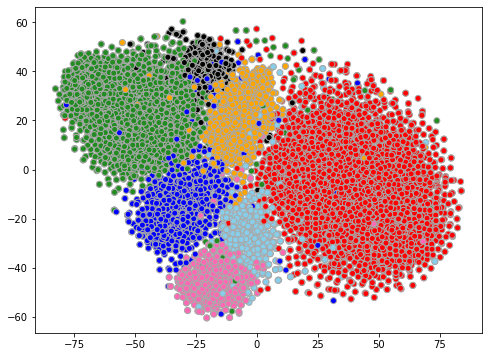

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
cl = []
for i in range(newmar.shape[0]):
    cl.append(colors[newlabels[i]])

def draw_edges(n):
    i = 0
    for e in nx.edges():
        #print(e)
        #print(w_embedded[e[0],:], w_embedded[e[1], :])
        x1 = w_embedded[e[0],0]
        y1 = w_embedded[e[0],1]
        x2 = w_embedded[e[1],0]
        y2 = w_embedded[e[1],1]
        a = [x1, x2]
        b = [y1, y2]
        plt.plot(a, b, c= [0.6, 0.6, 0.6], lw=0.2, zorder = 1)
        i+= 1
        if i > n:
            break
            
plt.figure(figsize=(8,6))
#draw_edges(g1.number_of_nodes())
plt.scatter(w_embedded[:,0], w_embedded[:,1], c=cl, edgecolors= 'darkgray',zorder = 2)
#plt.colorbar()
#plt.grid

            bioinformatics = hotpink
            machine learning = skyblue
            robotics = red
            theoretical-cs = orange
            networks = forest green
            security = black
            databases = blue